## Title: Convolutional Neural Network (CNN)
## Author: Tengku Muhammad Hanis Mokhtar
## Date: May16, 2024

* Basic workflow for CNN
* kaggle use R version 4.0.5, latest R version is 4.4.0

### Function
Define a function to plot the image. In RStudio, we can just use **imager** package. However, this package is not available for R version in kaggle.

In [1]:
plot_jpeg = function(path, add=FALSE)
{
  require('jpeg')
  jpg = readJPEG(path, native=T) # read the file
  res = dim(jpg)[1:2] # get the resolution, [x, y]
  if (!add) # initialize an empty plot area if add==FALSE
    plot(1,1,xlim=c(1,res[1]),ylim=c(1,res[2]),asp=1,type='n',xaxs='i',yaxs='i',xaxt='n',yaxt='n',xlab='',ylab='',bty='n')
  rasterImage(jpg,1,1,res[1],res[2])
}

### Load the required packages 
kaggle already have this packages, so no need for the installation

In [2]:
library(dplyr)
library(yardstick)
library(imager)
library(keras) 


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: magrittr


Attaching package: ‘imager’


The following object is masked from ‘package:magrittr’:

    add


The following object is masked from ‘package:dplyr’:

    where


The following objects are masked from ‘package:stats’:

    convolve, spectrum


The following object is masked from ‘package:graphics’:

    frame


The following object is masked from ‘package:base’:

    save.image



Attaching package: ‘keras’


The following object is masked from ‘package:yardstick’:

    get_weights




### Specify the path

In [4]:
train_dir <- "../input/skin-cancer/Data/train"
validation_dir <- "../input/skin-cancer/Data/validation"
test_dir <- "../input/skin-cancer/Data/test"

train_benign_dir <- file.path(train_dir, "benign")
train_malignant_dir <- file.path(train_dir, "malignant")

validation_benign_dir <- file.path(validation_dir, "benign")
validation_malignant_dir <- file.path(validation_dir, "malignant")

test_benign_dir <- file.path(test_dir, "benign")
test_malignant_dir <- file.path(test_dir, "malignant")

### Check the number of samples 

In [5]:
num_train_benign <- length(list.files(train_benign_dir))
num_train_malignant <- length(list.files(train_malignant_dir))

num_validation_benign <- length(list.files(validation_benign_dir))
num_validation_malignant <- length(list.files(validation_malignant_dir))

num_test_benign <- length(list.files(test_benign_dir))
num_test_malignant <- length(list.files(test_malignant_dir))

total_train <- num_train_benign + num_train_malignant
total_validation <- num_validation_benign + num_validation_malignant
total_test <- num_test_benign + num_test_malignant

paste("Training set:", total_train)
paste("Validation set:", total_validation)
paste("Testing set:", total_test)

[1] "Training set: 700"

[1] "Validation set: 100"

[1] "Testing set: 200"

### Check the image
We can also plot the image

Loading required package: jpeg



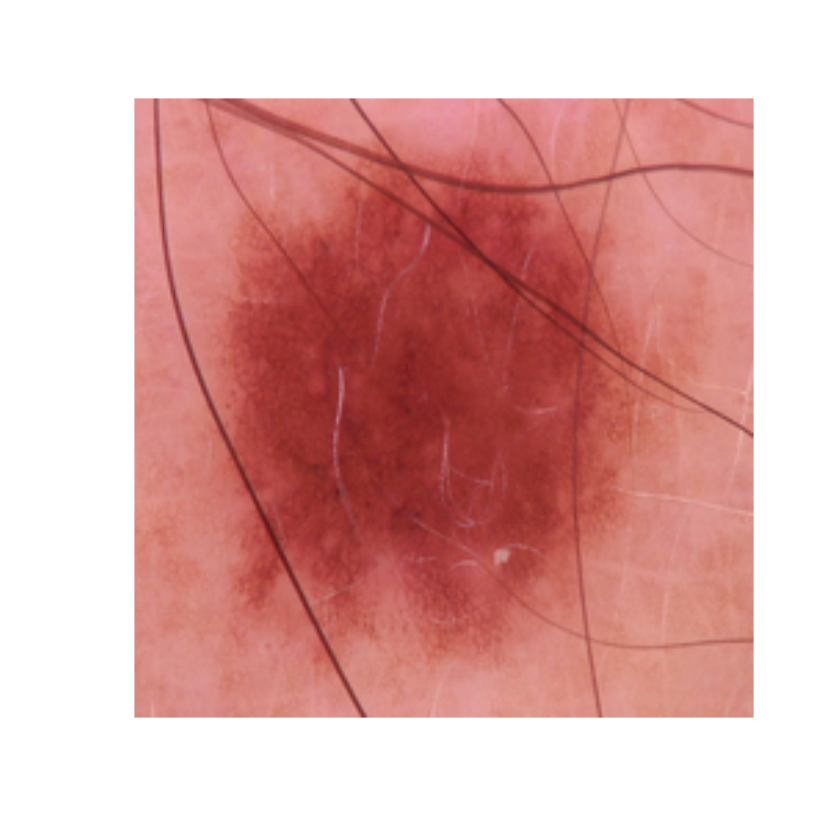

In [6]:
plot_jpeg("../input/skin-cancer/Data/train/benign/401.jpg")

### Data generator
Data generator allow us to train the data batch by batch

In [7]:
# Data generator
image_gen <- image_data_generator()

# Define batch size and image size
batch_size <- 100
IMG_HEIGHT <- 224  
IMG_WIDTH <- 224

# Data generator for each set
train_data_gen <- flow_images_from_directory(train_dir,
                                             generator = image_gen,
                                             batch_size = batch_size,
                                             target_size = c(IMG_HEIGHT,
                                                             IMG_WIDTH),
                                             class_mode = "binary")

validation_data_gen <- flow_images_from_directory(validation_dir,
                                                  generator = image_gen,
                                                  batch_size = batch_size,
                                                  target_size = c(IMG_HEIGHT,
                                                                  IMG_WIDTH),
                                                  class_mode = "binary")

test_data_gen <- flow_images_from_directory(test_dir,
                                            generator = image_gen,
                                            batch_size = batch_size,
                                            shuffle = FALSE,
                                            target_size = c(IMG_HEIGHT,
                                                            IMG_WIDTH),
                                            class_mode = "binary")


### Deep learning layers


In [8]:
# DL layers
inputs <- layer_input(shape = c(224, 224, 3))

outputs <- inputs %>%
  layer_rescaling(1 / 255) %>%
  layer_conv_2d(filters = 32, kernel_size = 3, activation = "relu") %>%
  layer_max_pooling_2d(pool_size = 2) %>%
  layer_conv_2d(filters = 64, kernel_size = 3, activation = "relu") %>%
  layer_max_pooling_2d(pool_size = 2) %>%
  layer_conv_2d(filters = 128, kernel_size = 3, activation = "relu") %>%
  layer_max_pooling_2d(pool_size = 2) %>%
  layer_conv_2d(filters = 256, kernel_size = 3, activation = "relu") %>%
  layer_max_pooling_2d(pool_size = 2) %>%
  layer_conv_2d(filters = 256, kernel_size = 3, activation = "relu") %>%
  layer_flatten() %>%
  layer_dropout(0.5) %>%
  layer_dense(1, activation = "sigmoid")

model <- keras_model(inputs, outputs)

# Compile
model %>% compile(loss = "binary_crossentropy",
                  optimizer = "adam",
                  metrics = "accuracy")

### Set up the callbacks

In [9]:
# Callbacks
callbacks <- list(
  callback_model_checkpoint(
    filepath = "dl_scratch_raw_images.h5",
    save_best_only = TRUE,
    monitor = "val_loss"
  ),
  callback_early_stopping(
    monitor = "val_loss",
    min_delta = 0.01,
    patience = 4)
)

### Fit the model

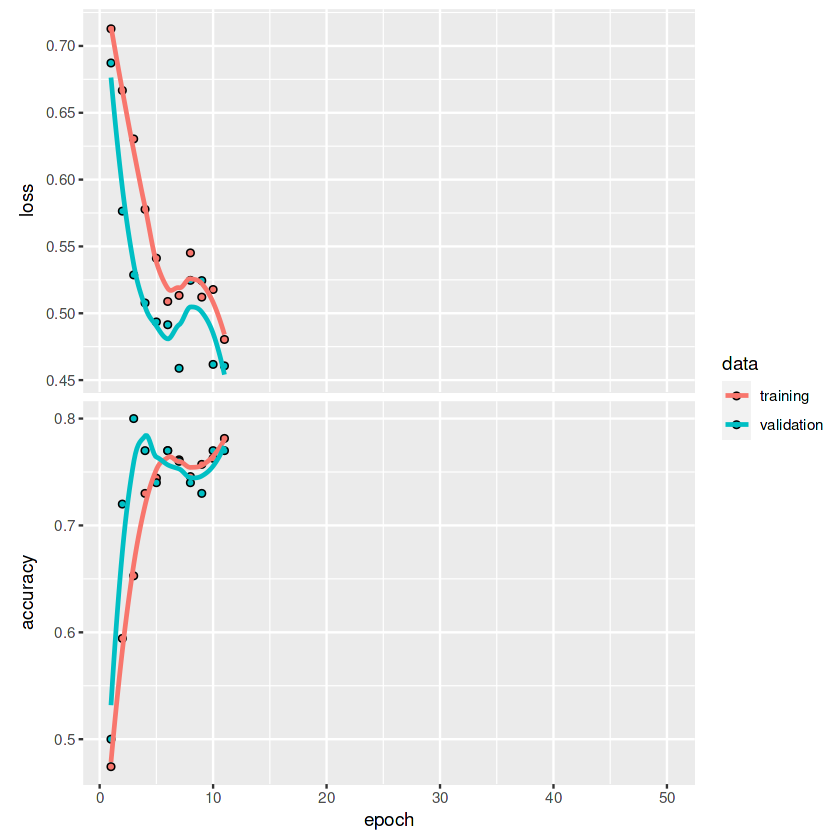

In [10]:
# This will run about ~ 10-15 min
history <- model %>% fit(
  train_data_gen,
  epochs = 50,
  validation_data = validation_data_gen,
  callbacks = callbacks
)
plot(history)

### Performance on the testing set

In [11]:
test_model <- load_model_tf("dl_scratch_raw_images.h5")
result <- evaluate(test_model, test_data_gen)
cat(sprintf("Test accuracy: %.3f\n", result["accuracy"])) 

Test accuracy: 0.750


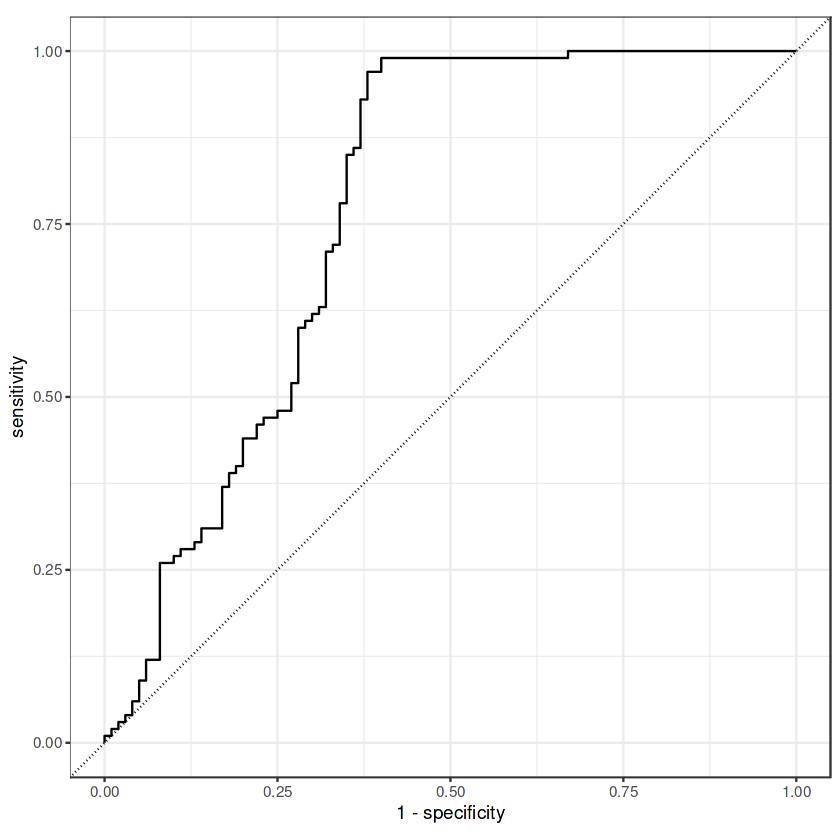

In [13]:
# Other metrics - ROC plot
metric_dat <- 
  test_model %>% 
  predict(test_data_gen) %>% 
  as_tibble() %>% 
  rename(prob = V1) %>% 
  mutate(label = test_data_gen$labels,
         label = as.factor(label))

metric_dat %>% 
  roc_curve(label, prob, event_level = "second") %>% 
  tune::autoplot()

In [14]:
# Other metrics - multiset
multi_metric <- metric_set(roc_auc, pr_auc)
multi_metric2 <- metric_set(sens, spec)

metric_dat %>% 
  multi_metric(label, prob, event_level = "second") %>% 
  bind_rows(
    metric_dat %>% 
      mutate(pred = ifelse(prob > 0.5, 1, 0),
             pred = as.factor(pred)) %>% 
      multi_metric2(truth = label, estimate = pred, event_level = "second")
  )

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.7696000
pr_auc,binary,0.6772015
sens,binary,0.8700000
spec,binary,0.6300000


### Predict a new image

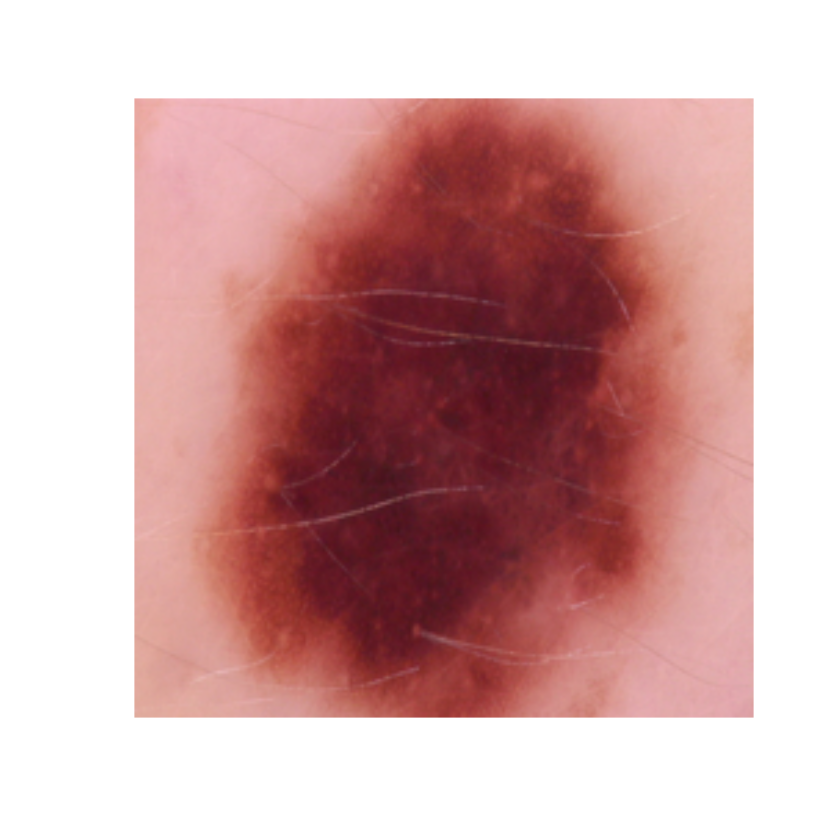

In [15]:
# New image
plot_jpeg("../input/skin-cancer/Data/train/benign/384.jpg")

In [16]:
# Change the new image into a proper format
new_img <- 
  image_load("../input/skin-cancer/Data/train/benign/384.jpg",
                      target_size = c(224, 224)) %>% 
  image_to_array() %>% 
  array_reshape(c(1, 224, 224, 3))

# Predict the new image
pred <- 
  test_model %>% 
  predict(new_img) 

pred %>% 
  as_tibble(.name_repair = NULL) %>% 
  mutate(diabetes = ifelse(V1 > 0.5, "malignant", "benign")) %>% 
  rename(prob = V1)

prob,diabetes
<dbl>,<chr>
0.02113467,benign
